In [264]:
import os
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
import plotnine as gg
from plotnine import *
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from sklearn.manifold import TSNE
from palettable.colorbrewer.sequential import *
from pathlib import Path
import umap.umap_ as umap
from scipy import stats
from scipy.stats import ttest_ind


In [284]:

outpath = "/Users/habbasi/Documents/Github/broadinstitute/ProteinKinase_NathianelGray/Figures/TSNE_PCA/"

def makedirectory(path):
    try:
        if not os.path.exists(path):
            
            return os.mkdir(path)
    except OSError as e: 
        print("inside exception", e)
        sys.exit()

makedirectory(outpath)    

## Data Paths

In [285]:
path = Path("../collated/")
#outpath = Path("/Welch_ttest/")
fname = "C-7210-01-CMP-008-gray_collapsed_sampled.csv"
fpath = os.path.join(path, fname)
df = pd.read_csv(fpath)


metadata = [col for col in df.columns if "Metadata" in col]
var = [col for col in df.columns if not "Metadata" in col]

## Note some of the Costes features are not removed and have to be removed

exclude_var = ['Cells_Correlation_Costes_DNA_Mito',
 'Cytoplasm_Correlation_Costes_DNA_Mito',
 'Cytoplasm_Correlation_Costes_DNA_RNA']

variables = [v for v in var if v not in exclude_var]
len(variables)

595

## UMAP

In [267]:
reducer=umap.UMAP(random_state=np.random.RandomState(0))
embedding = reducer.fit_transform(df.loc[:, variables].values)


test = pd.DataFrame(embedding, columns= ['UMAP-1', 'UMAP-2'])
combined = test.merge(df.loc[:, metadata], left_index=True, right_index=True)




In [268]:
combined.columns

Index(['UMAP-1', 'UMAP-2', 'Metadata_Plate', 'Metadata_Well',
       'Metadata_broad_sample', 'Metadata_Assay_Plate_Barcode',
       'Metadata_Plate_Map_Name', 'Metadata_cell_line',
       'Metadata_well_position', 'Metadata_mg_per_ml',
       'Metadata_mmoles_per_liter', 'Metadata_solvent', 'Metadata_cell_id',
       'Metadata_pert_id', 'Metadata_pert_mfc_id', 'Metadata_pert_well',
       'Metadata_pert_id_vendor', 'Metadata_broad_sample_type',
       'Metadata_pert_vehicle', 'Metadata_pert_type', 'Metadata_label',
       'Metadata_chemist', 'Metadata_compound_name', 'Metadata_Annotation',
       'Metadata_Target', 'Metadata_Broad_barcode'],
      dtype='object')

## Data structuring for analysis

In [269]:
combined['Metadata_Target'].replace([np.nan, 'CDK14 / pan-TAIRE'], ['Controls', 'CDK14_pan-TAIRE'], inplace=True)
combined['Metadata_Annotation'].replace('active ', 'active', inplace=True)
combined['Metadata_combined_name'] = combined['Metadata_compound_name'] + "_{" + combined['Metadata_Annotation'] + "}_" + combined['Metadata_Target']

combined['Metadata_test'] = combined['Metadata_compound_name'] + "_" + combined['Metadata_Annotation']
combined['Metadata_test'].replace(['DMSO_control', 'C4_control', 'C3_control', 'C2_control', 'C1_control'], 
                                                                       'Controls', inplace=True)

print(combined['Metadata_combined_name'].unique())


['DMSO_{control}_Controls' 'FMF-03-146-1_{active}_DCLK1'
 'BJP-06-115-3_{inactive}_PIN1' 'BJP-06-005-3_{active}_PIN1'
 'C4_{control}_Controls' 'FMF-04-112-1_{inactive}_DCLK1'
 'JWG-071_{active}_ERK5' 'PND-1186_{active}_FAK' 'C3_{control}_Controls'
 'FMF-04-159-2_{covalent}_CDK14_pan-TAIRE' 'AX15836_{active}_ERK5'
 'BSJ-04-030_{inactive (protac)}_SECRET' 'C2_{control}_Controls'
 'FMF-05-176-1_{reversible}_CDK14_pan-TAIRE' 'JWG-119_{inactive}_ERK5'
 'BSJ-03-136_{active (protac)}_SECRET' 'C1_{control}_Controls']


## Plotting UMAP for all drugs

/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Documents/Github/broadinstitute/ProteinKinase_NathianelGray/Figures/UMAP/per_drug/umap_allcompounds.png
/Users/habbasi/plotnine/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 16 rows containing missing values.
/Users/habbasi/plotnine/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 16 rows containing missing values.


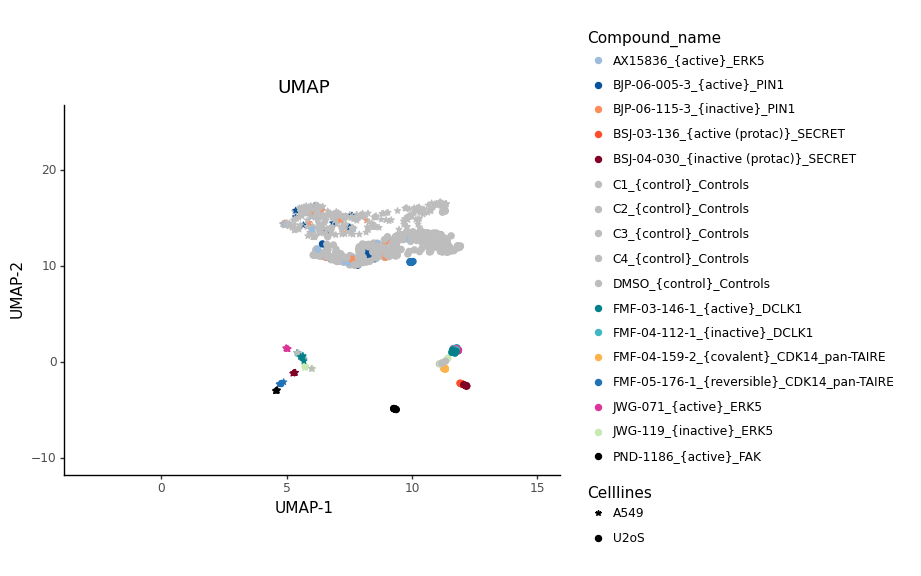

<ggplot: (7021942381)>

In [278]:
map_colors = {'DMSO_{control}_Controls':'#bdbdbd',
              'FMF-03-146-1_{active}_DCLK1':'#02818a',
              'BJP-06-115-3_{inactive}_PIN1': '#fc8d59',
              'BJP-06-005-3_{active}_PIN1': '#08519c',
              'C4_{control}_Controls':'#bdbdbd',
              'FMF-04-112-1_{inactive}_DCLK1': '#41b6c4',
              'JWG-071_{active}_ERK5': '#dd3497',
              'PND-1186_{active}_FAK':'#000000',
              'C3_{control}_Controls':'#bdbdbd',
              'FMF-04-159-2_{covalent}_CDK14_pan-TAIRE': '#feb24c',
              'AX15836_{active}_ERK5':'#9ebcda',
              'BSJ-04-030_{inactive (protac)}_SECRET': '#800026',
              'C2_{control}_Controls':'#bdbdbd',
              'FMF-05-176-1_{reversible}_CDK14_pan-TAIRE': '#2171b5',
              'JWG-119_{inactive}_ERK5': '#c7e9b4',
              'BSJ-03-136_{active (protac)}_SECRET': '#fc4e2a',
              'C1_{control}_Controls':'#bdbdbd',
            
             }


g = gg.ggplot(combined, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_combined_name', shape="Metadata_cell_line")) + \
gg.geom_point(size = 2) + \
gg.xlab("UMAP-1") + \
gg.ylab("UMAP-2") + \
gg.xlim(-3,15) + \
gg.ylim(-10,25) + \
gg.theme_classic() + \
gg.scale_colour_manual(name= 'Compound_name', values=map_colors) + \
gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o']) + \
gg.labs(title="UMAP")
ggsave(filename='umap_allcompounds.png', plot = g, path=outpath)
    
g    



## Plotting Umap for individual Target

In [277]:
map_colors = {'Controls': '#bdbdbd',
              'FMF-03-146-1_active': '#02818a',
              'BJP-06-115-3_inactive': '#fc8d59',
              'BJP-06-005-3_active': '#08519c',
              'FMF-04-112-1_inactive': '#41b6c4',
              'JWG-071_active': '#dd3497',
              'PND-1186_active':'#000000',
              'FMF-04-159-2_covalent': '#feb24c',
              'AX15836_active':'#9ebcda',
              'BSJ-04-030_inactive (protac)': '#800026',
              'FMF-05-176-1_reversible': '#2171b5',
              'JWG-119_inactive': '#c7e9b4',
              'BSJ-03-136_active (protac)': '#fc4e2a'
              
              
             }

lst = combined.Metadata_Target.unique()


lst = list(filter(lambda x: x != "Controls", lst))

for i in lst:
    
    options = ['Controls', i]
    d = combined.loc[combined['Metadata_Target'].isin(options)]
    
    g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_test', shape="Metadata_cell_line")) + \
    gg.geom_point(size = 2) + \
    gg.xlab("UMAP-1") + \
    gg.ylab("UMAP-2") + \
    gg.ggtitle(i) + \
    gg.xlim(-15,20) + \
    gg.ylim(-10,25) + \
    gg.theme_classic() + \
    gg.scale_colour_manual(name= 'Compound_name', values=map_colors) + \
    gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
    ggsave(filename='umap_' + i + '.png', plot = g, path=outpath)
    
    






/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Documents/Github/broadinstitute/ProteinKinase_NathianelGray/Figures/UMAP/per_drug/umap_DCLK1.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Documents/Github/broadinstitute/ProteinKinase_NathianelGray/Figures/UMAP/per_drug/umap_PIN1.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Documents/Github/broadinstitute/ProteinKinase_NathianelGray/Figures/UMAP/per_drug/umap_ERK5.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename

## T-SNE

In [286]:
# Fit and transform with t-SNE

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, learning_rate=100, n_iter=1000, perplexity=30)


#Project the data in 2D 
x_2d = model.fit_transform(df.loc[:, variables].values)

test = pd.DataFrame(x_2d, columns= ['t-SNE-1', 't-SNE-2'])

combined = test.merge(df.loc[:, metadata], left_index=True, right_index=True)

combined['Metadata_Target'].replace([np.nan, 'CDK14 / pan-TAIRE'], ['Controls', 'CDK14_pan-TAIRE'], inplace=True)
combined['Metadata_Annotation'].replace('active ', 'active', inplace=True)
combined['Metadata_combined_name'] = combined['Metadata_compound_name'] + "_{" + combined['Metadata_Annotation'] + "}_" + combined['Metadata_Target']
combined['Metadata_test'] = combined['Metadata_compound_name'] + "_" + combined['Metadata_Annotation']
combined['Metadata_test'].replace(['DMSO_control', 'C4_control', 'C3_control', 'C2_control', 'C1_control'], 
                                                                       'Controls', inplace=True)



## Plotting

/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Documents/Github/broadinstitute/ProteinKinase_NathianelGray/Figures/TSNE_PCA/Gray_project_t-SNE.png


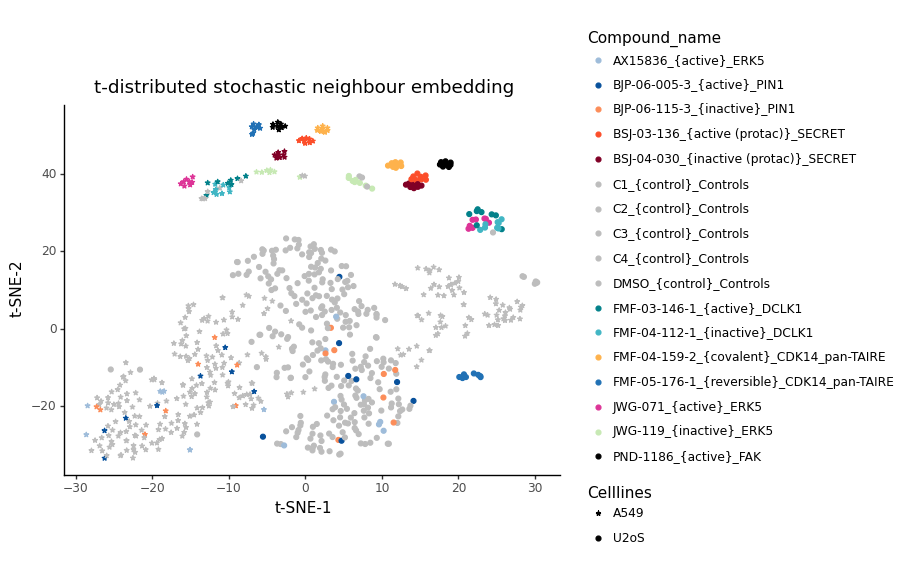

<ggplot: (7017930441)>

In [287]:
map_colors = {'DMSO_{control}_Controls':'#bdbdbd',
              'FMF-03-146-1_{active}_DCLK1':'#02818a',
              'BJP-06-115-3_{inactive}_PIN1': '#fc8d59',
              'BJP-06-005-3_{active}_PIN1': '#08519c',
              'C4_{control}_Controls':'#bdbdbd',
              'FMF-04-112-1_{inactive}_DCLK1': '#41b6c4',
              'JWG-071_{active}_ERK5': '#dd3497',
              'PND-1186_{active}_FAK':'#000000',
              'C3_{control}_Controls':'#bdbdbd',
              'FMF-04-159-2_{covalent}_CDK14_pan-TAIRE': '#feb24c',
              'AX15836_{active}_ERK5':'#9ebcda',
              'BSJ-04-030_{inactive (protac)}_SECRET': '#800026',
              'C2_{control}_Controls':'#bdbdbd',
              'FMF-05-176-1_{reversible}_CDK14_pan-TAIRE': '#2171b5',
              'JWG-119_{inactive}_ERK5': '#c7e9b4',
              'BSJ-03-136_{active (protac)}_SECRET': '#fc4e2a',
              'C1_{control}_Controls':'#bdbdbd',
            
             }




p = gg.ggplot(combined, gg.aes(x='t-SNE-1', y='t-SNE-2', color='Metadata_combined_name', label='Metadata_compound_name', shape='Metadata_cell_line')) + \
    gg.geom_point() + \
    gg.theme_classic() + \
    gg.xlab("t-SNE-1") + \
    gg.ylab("t-SNE-2") + \
    gg.ggtitle("t-distributed stochastic neighbour embedding") + \
    gg.scale_colour_manual(name= 'Compound_name', values=map_colors) + \
    gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])

    

ggsave(filename='Gray_project_t-SNE.png', plot = p, path = outpath)
    
p
